# 0.0. Step 0 - Imports

In [64]:
import math
import numpy as np
import pandas as pd
import inflection
import seaborn as sns

from scipy                import stats as ss
from numpy                import int64
from matplotlib           import pyplot as plt

from IPython.core.display import HTML

from tabulate             import tabulate


## 0.1. Helper Functions 

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [20, 12]
    plt.rcParams['font.size'] = 25
    
    display(HTML( '<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
            
    sns.set() 

In [3]:
jupyter_settings ()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

# 1.0. Step 1 - Descrição dos Dados

## 1.1. Data

In [4]:
df_sales_raw = pd.read_csv ('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv ('data/store.csv', low_memory = False)

#merge
df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df1 = df_raw.copy()

## 1.2. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.3. Data Dimensions

In [7]:
print('Number of Rows {}'.format(df1.shape[0]))
print('Number od Columns {}'.format(df1.shape[1]))

Number of Rows 1017209
Number od Columns 18


## 1.4. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.5. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.6. Fillout NA

In [10]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 2000000.0 if math.isnan (x) else (x))

#competition_open_since_month  
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year    
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )

#promo2_since_week              
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1 )

#promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

#promo_interval
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map' ]].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',') else 0, axis=1)


## 1.7. Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int64)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int64)

## 1.8. Descriptive Statistical

### 1.7.1. Split data in numerical and categorical attributes

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])

### 1.7.2 Numerical Attributes

In [13]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,2000000.0,1999980.0,10610.588099,2330.0,101810.649100,19.378002,375.644405
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


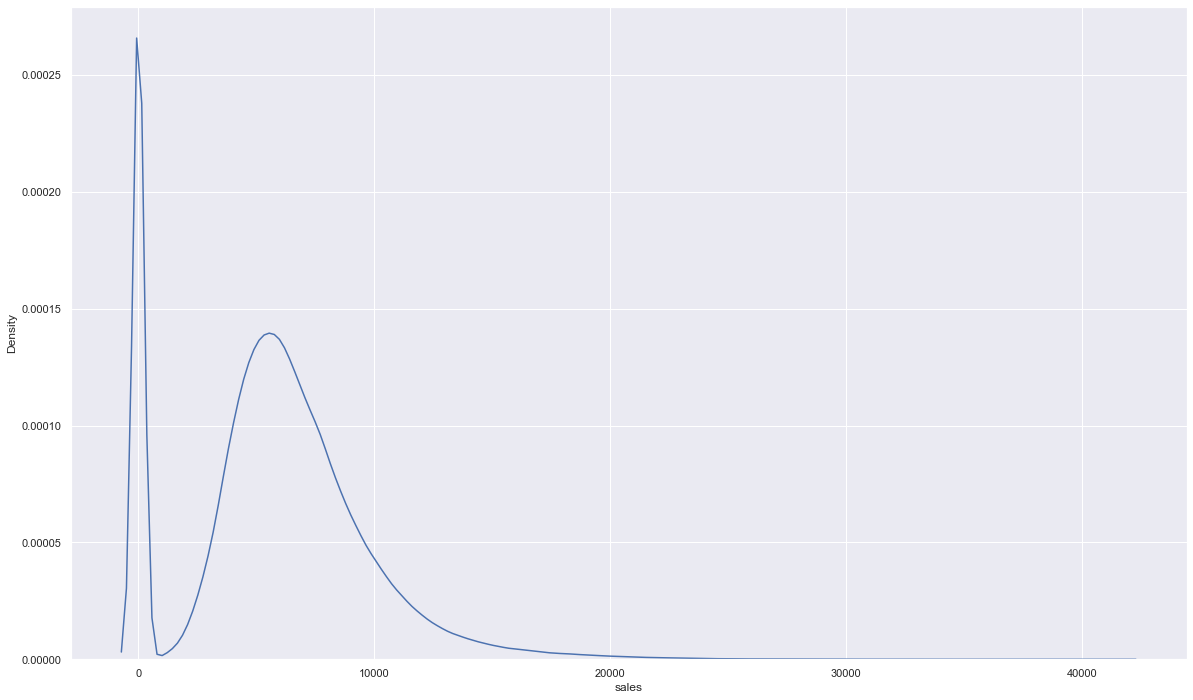

In [14]:
sns.kdeplot(df1['sales']);

### 1.7.3 Categorical Attributes

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

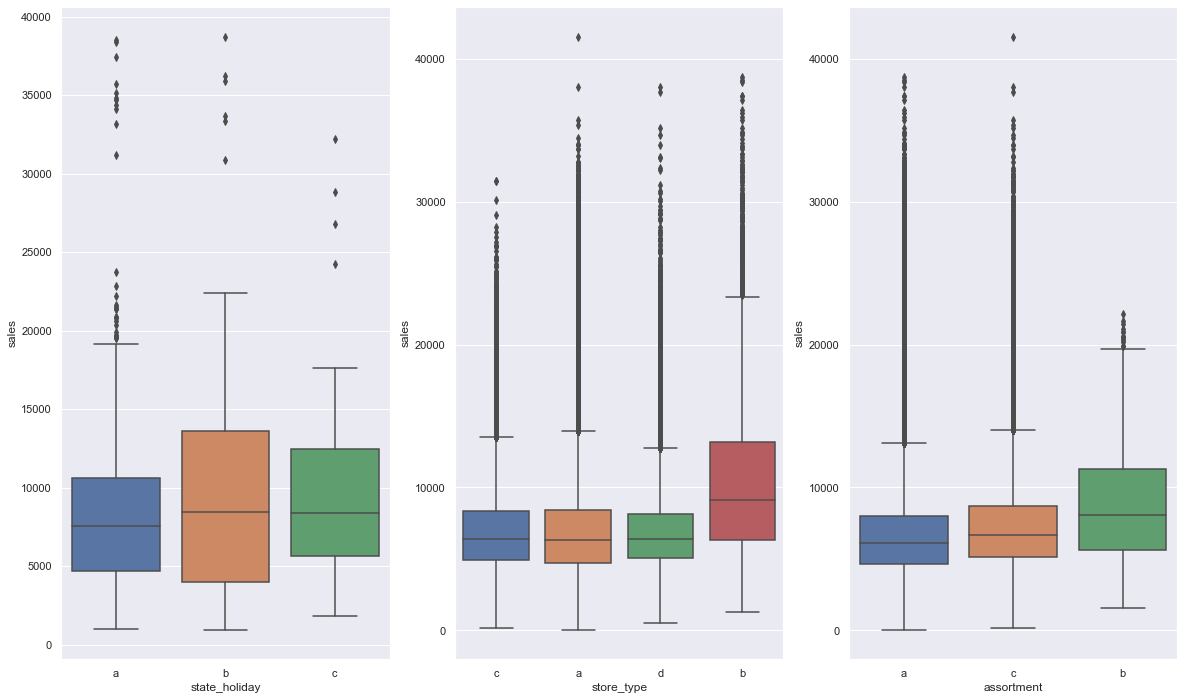

In [16]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
aux2 = df1[df1['sales'] > 0]

plt.subplot(131)
sns.boxplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(132)
sns.boxplot(x='store_type', y='sales', data=aux2);

plt.subplot(133)
sns.boxplot(x='assortment', y='sales', data=aux2);

# 2.0. Step 2 - Feature Engineering

### 2.1. Data

In [17]:
df2 = df1

### 2.2. Mind Map Hypothesis

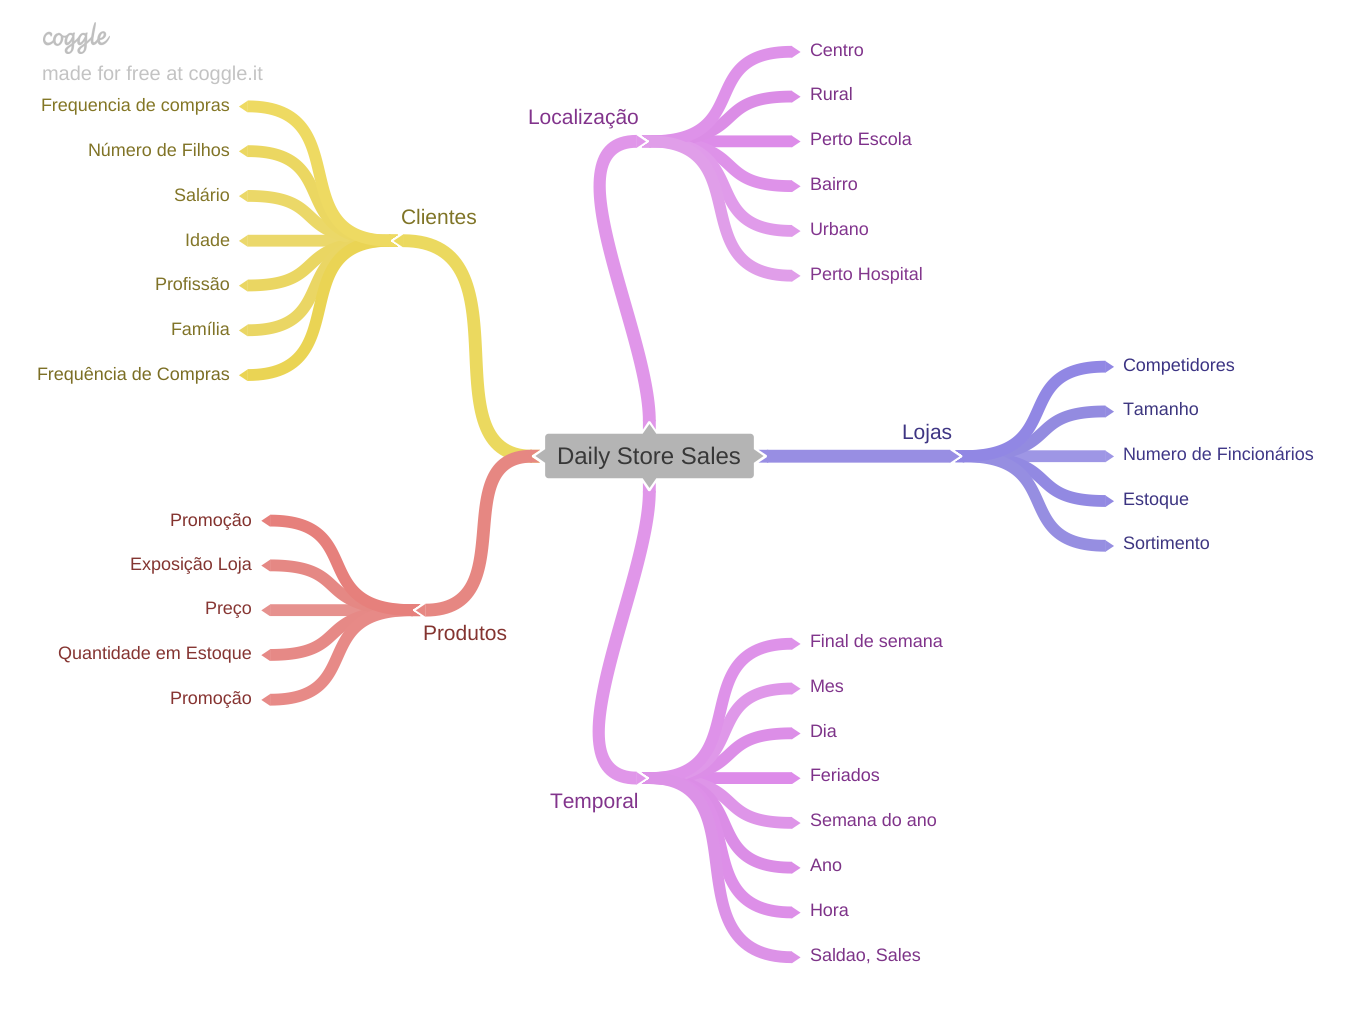

In [18]:
Image('img/MindMapHypothesis.png')

### 2.3. Create Hypothesis

#### 2.3.1. Store Hypothesis

1.Lojas com número maior de funcionários deveriam vender mais.

2.Lojas com maior capacidade de estoque deveriam vender mais.

3.Lojas com maior porte deveriam vender mais.

4.Lojas com maior sortimentos deveriam vender mais.

5.Lojas com competidores mais próximos deveriam vender menos.

6.Lojas com competidores à mais tempo deveriam vendem mais.

#### 2.3.2. Product Hypothesis

**1**.Lojas que investem mais em Marketing deveriam vender mais.

**2**.Lojas com maior exposição de produto deveriam vender mais.

**3**.Lojas com produtos com preço menor deveriam vender mais.

**5**.Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6**.Lojas com promoções ativas por mais tempo deveriam vender mais.

**7**.Lojas com mais dias de promoção deveriam vender mais.

**8**.Lojas com mais promoções consecutivas deveriam vender mais.

#### 2.3.3. Time Hypothesis (seasonality)

**1**.Lojas abertas durante o feriado de Natal deveriam vender mais.

**2**.Lojas deveriam vender mais ao longo dos anos.

**3**.Lojas deveriam vender mais no segundo semestre do ano.

**4**.Lojas deveriam vender mais depois do dia 10 de cada mês.

**5**.Lojas deveriam vender menos aos finais de semana.

**6**.Lojas deveriam vender menos durante os feriados escolares.

### 2.4. Final List Hypothesis

**1**.Lojas com maior sortimentos deveriam vender mais.

**2**.Lojas com competidores mais próximos deveriam vender menos.

**3**.Lojas com competidores à mais tempo deveriam vendem mais.

**4**.Lojas com promoções ativas por mais tempo deveriam vender mais.

**5**.Lojas com mais dias de promoção deveriam vender mais.

**6**.Lojas com mais promoções consecutivas deveriam vender mais.

**7**.Lojas abertas durante o feriado de Natal deveriam vender mais.

**8**.Lojas deveriam vender mais ao longo dos anos.

**9**.Lojas deveriam vender mais no segundo semestre do ano.

**10**.Lojas deveriam vender mais depois do dia 10 de cada mês.

**11**.Lojas deveriam vender menos aos finais de semana.

**12**.Lojas deveriam vender menos durante os feriados escolares.

### 2.3 Feature Engineering

In [19]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year of week
df2['year_of_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int64)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2 ['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x : x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


# 3.0. Step 3 - Feature Filtering

## 3.1. Data

In [20]:
df3 = df2

## 3.2. Filtering Rowns

In [21]:
df3 = df3[(df3['open'] !=0) & (df3['sales'] > 0)]

## 3.3. Filtering Columns

In [22]:
cols_drop =['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. Step 4 - Exploratory Data Analysis

## 4.1. Data

In [23]:
df4 = df3

## 4.2. Análise Univariada

### 4.2.1. Response Variable

C:\Users\DML1WFE\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


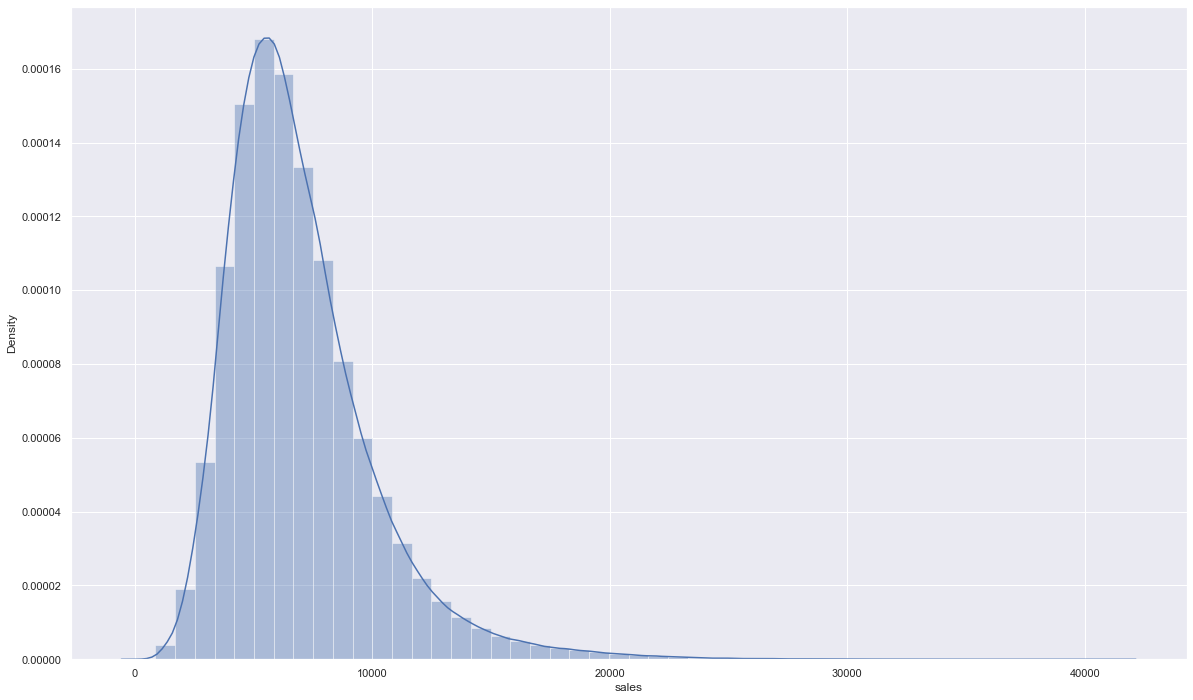

In [24]:
sns.distplot(df4['sales']);

### 4.1.2 Numerical Variable

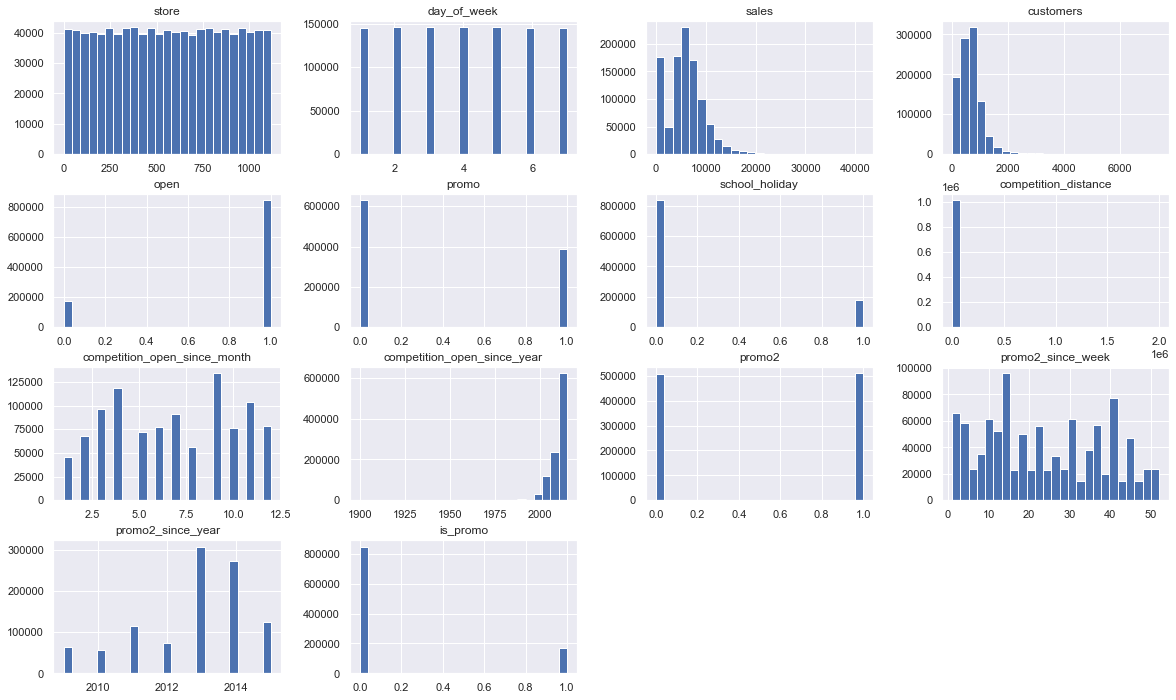

In [25]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

In [26]:
df4['store_type'].drop_duplicates().head()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

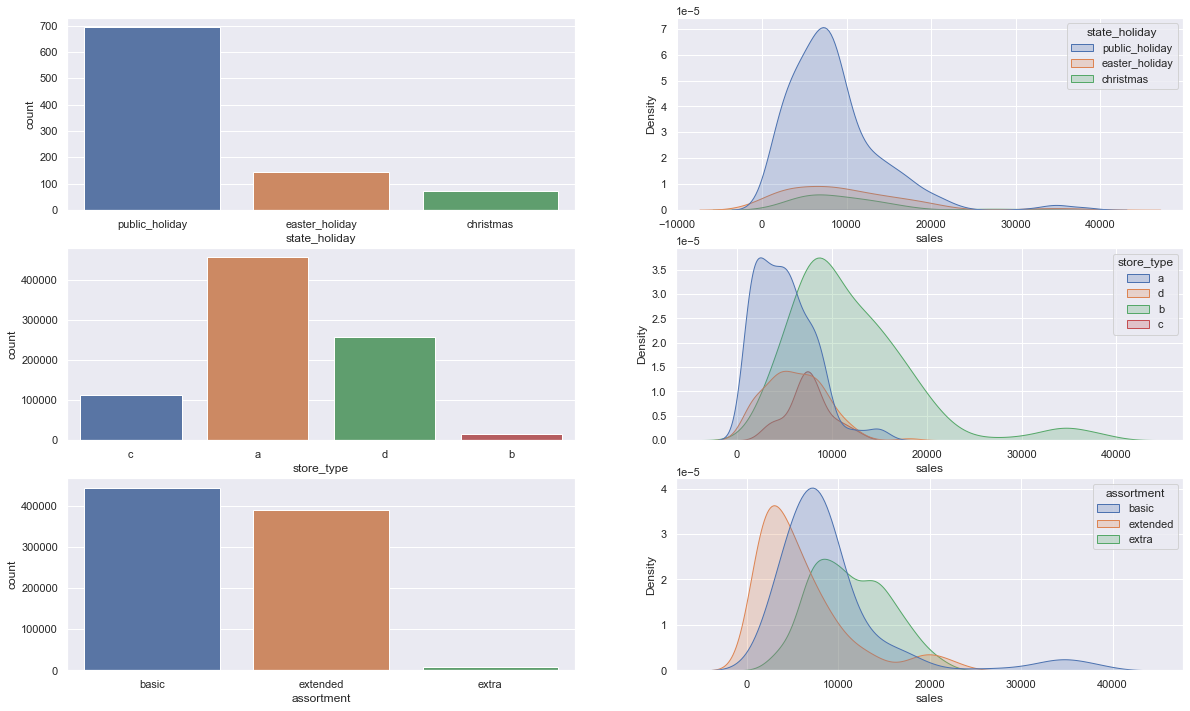

In [27]:
#state Holiday
plt.subplot(321)
a = df4[(df4['state_holiday'] != 'regular_day')]
sns.countplot(x="state_holiday", data=a);

plt.subplot(322)
sns.kdeplot(data=a, x='sales', hue='state_holiday', shade='True');

#Store Type
plt.subplot(323)
sns.countplot(x='store_type', data=df4);

plt.subplot(324)
sns.kdeplot(data=a, x='sales', hue='store_type', shade='True');

#assortment
plt.subplot(325)
sns.countplot(x='assortment', data=df4);

plt.subplot(326)
sns.kdeplot(data=a, x='sales', hue='assortment', shade='True');

## 4.3. Análise Bivariada

### 4.3.1 Hypothesis Test

#### H1. Lojas com maior sortimentos deveriam vender mais?
**False** Lojas com maior sortimento vendem menos

<AxesSubplot:xlabel='year_of_week'>

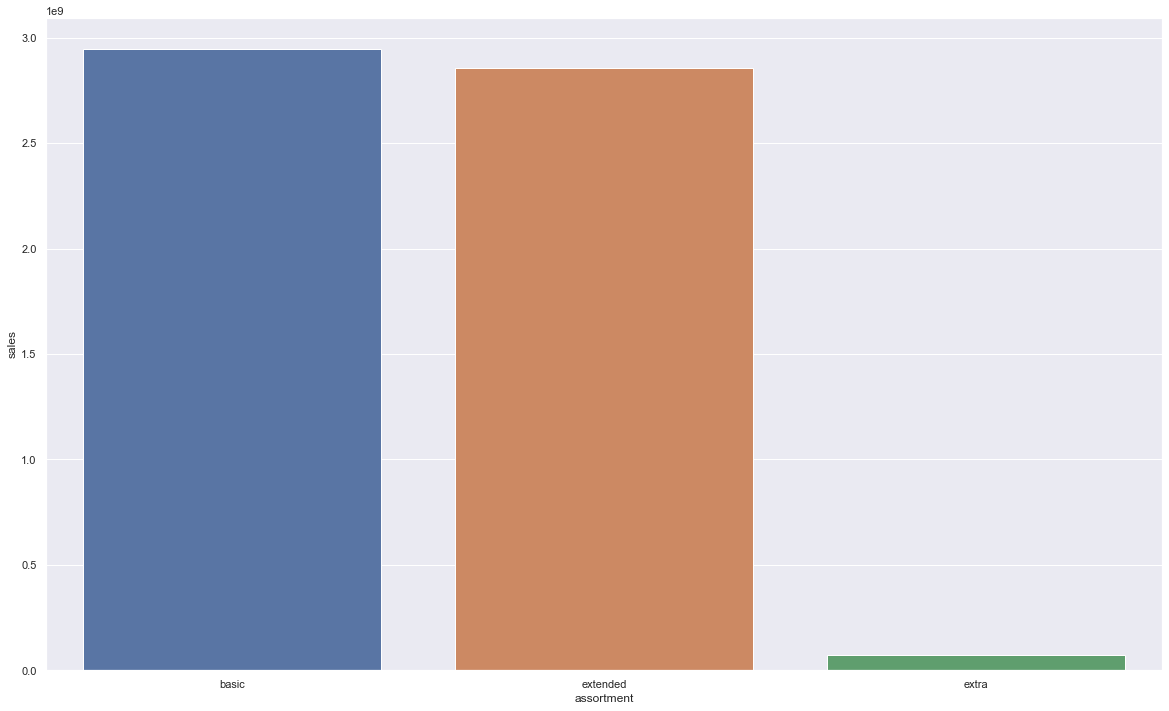

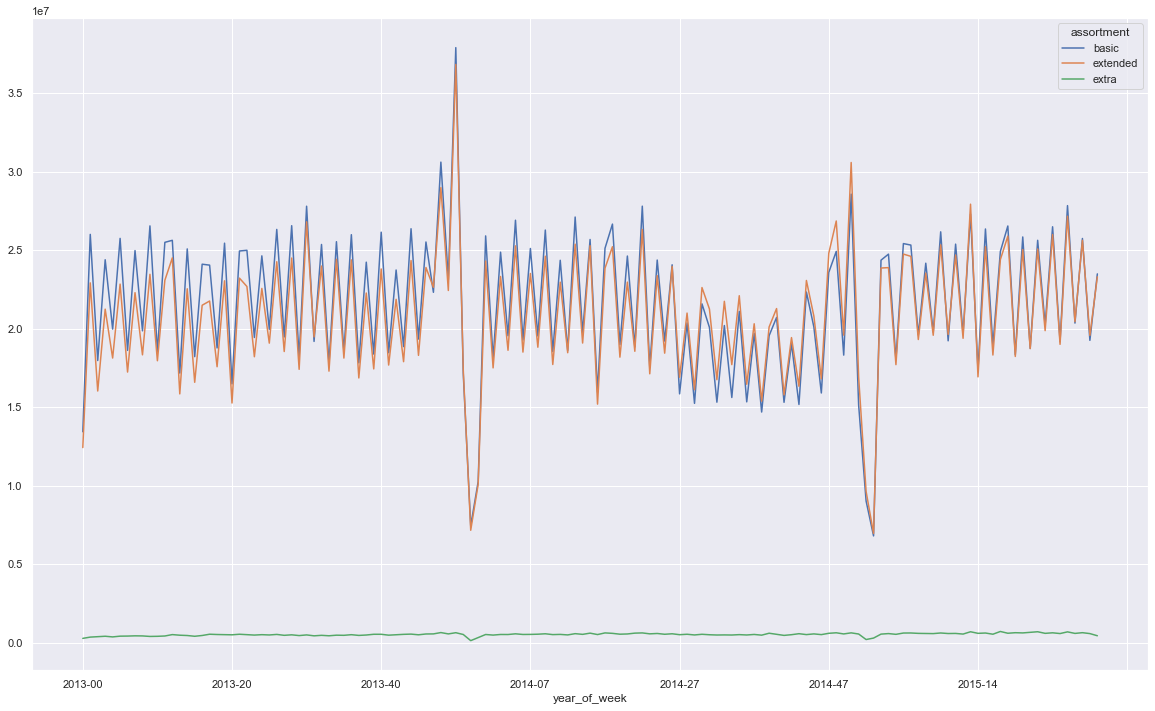

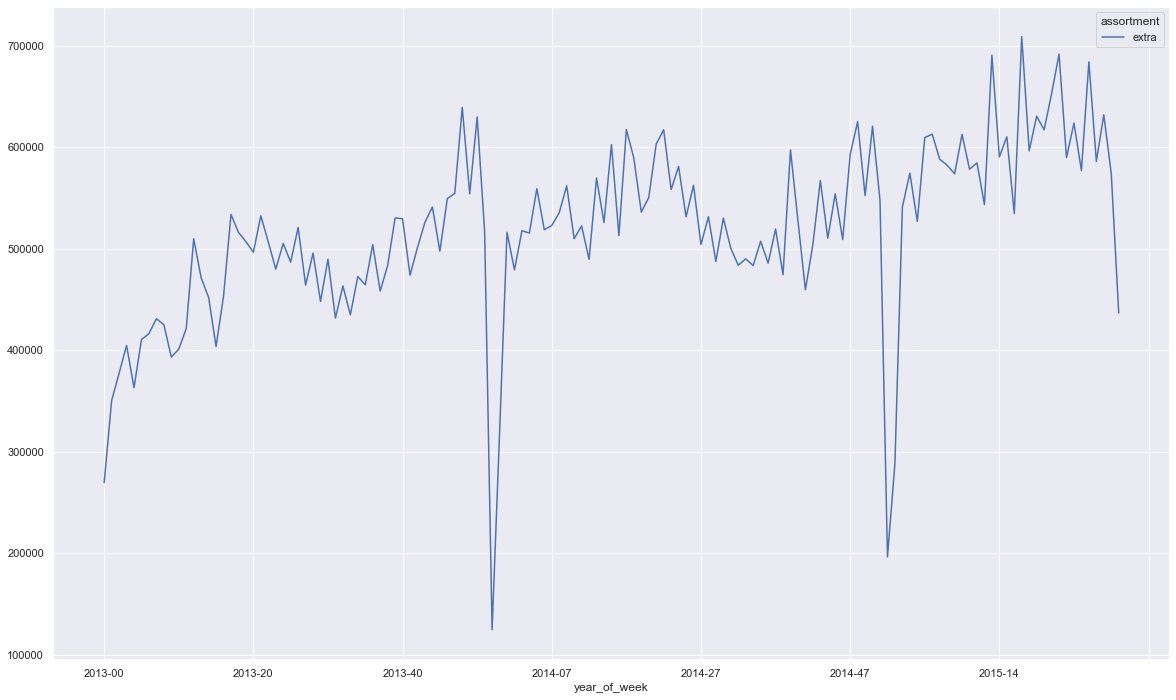

In [28]:
aux1 = df4[['assortment', 'sales']].groupby ('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_of_week', 'assortment', 'sales']].groupby(['year_of_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_of_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_of_week', columns = 'assortment', values= 'sales').plot()

#### H2. Lojas com competidores mais próximos deveriam vender menos.
**False** Lojas com competidores proximos vendem mais

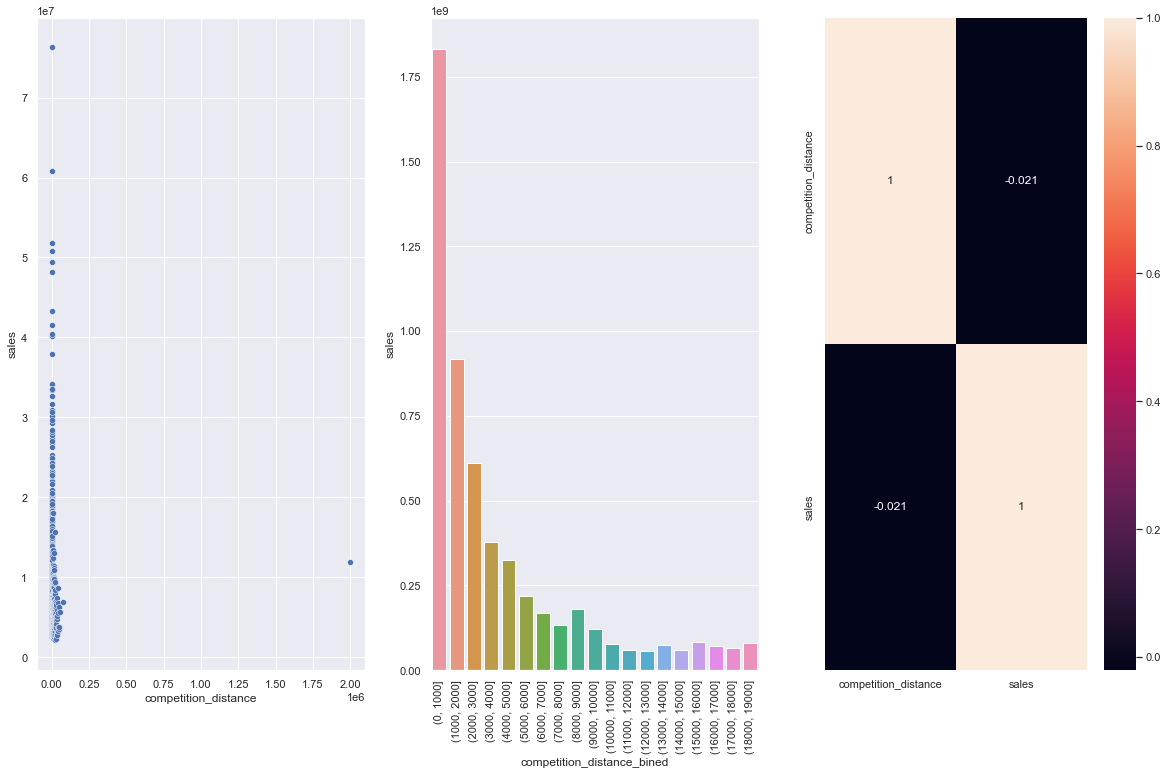

In [29]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(131)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(132)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_bined'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_bined', 'sales']].groupby('competition_distance_bined').sum().reset_index()
sns.barplot(x='competition_distance_bined', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(133)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


#### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**False** Lojas competidores a mais tempo vendem menos

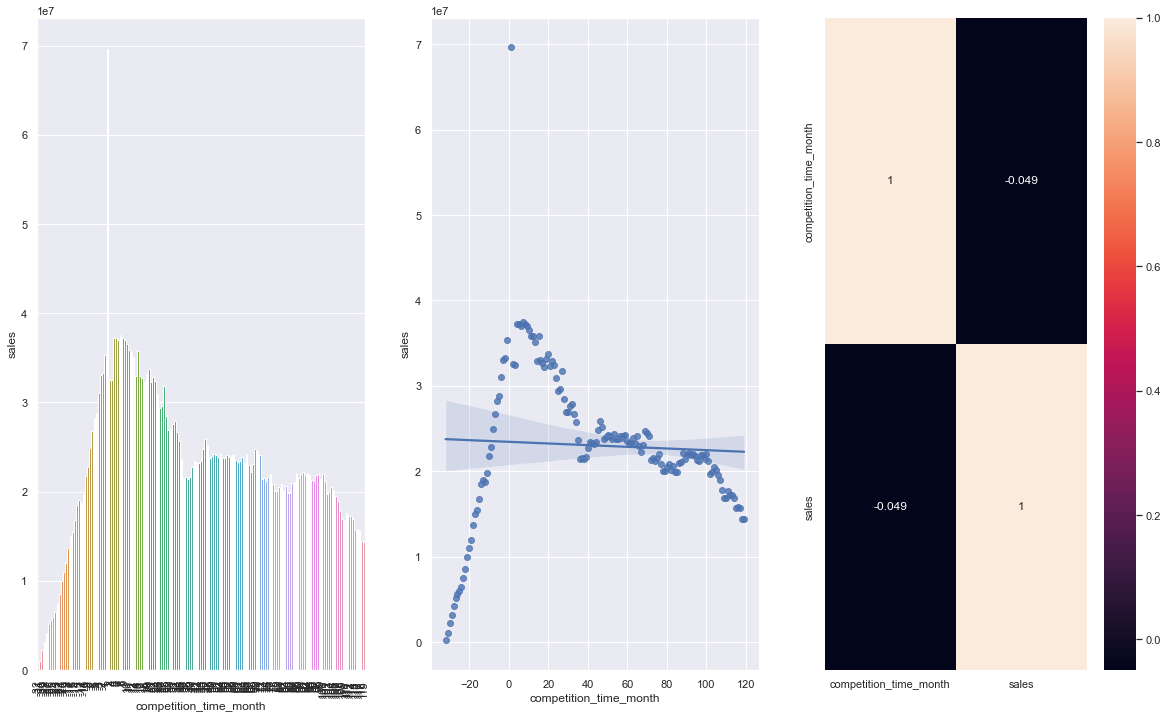

In [30]:
plt.subplot(131)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(132)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(133)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

#### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**False** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção

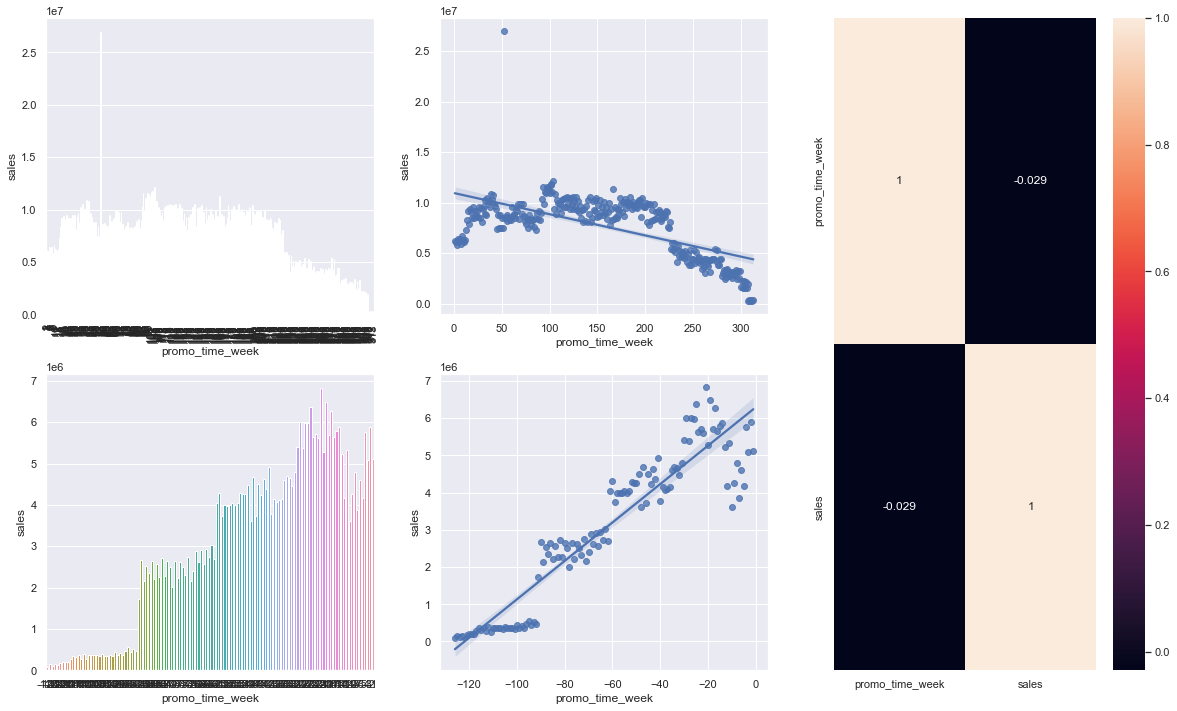

In [31]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot (grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x='promo_time_week', y ='sales', data = aux2);
plt.xticks (rotation=90);

plt.subplot (grid[0,1])
sns.regplot(x='promo_time_week', y ='sales', data = aux2);

plt.subplot (grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y ='sales', data = aux3);

plt.subplot (grid[1,1])
sns.regplot(x='promo_time_week', y ='sales', data = aux3);

plt.subplot (grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

####  <s> H5. Lojas com mais dias de promoção deveriam vender mais.</s>

#### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**False** Lojas com mais promoções consecutivas vendem menos

In [32]:
df4[['promo', 'promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


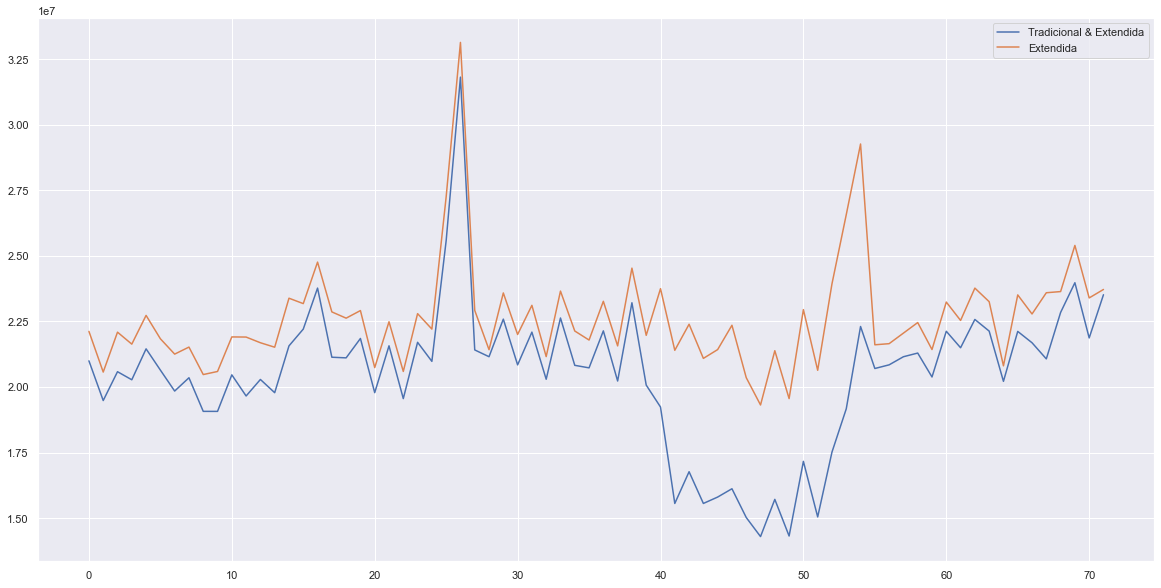

In [33]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_of_week', 'sales']].groupby('year_of_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_of_week', 'sales']].groupby('year_of_week').sum().reset_index()

aux2.plot(figsize=(20, 10), ax = ax)

ax.legend(labels=('Tradicional & Extendida', 'Extendida'));

#### H7. Lojas no feriado de Natal vendem mais.
**False** Lojas vendem menos no Natal

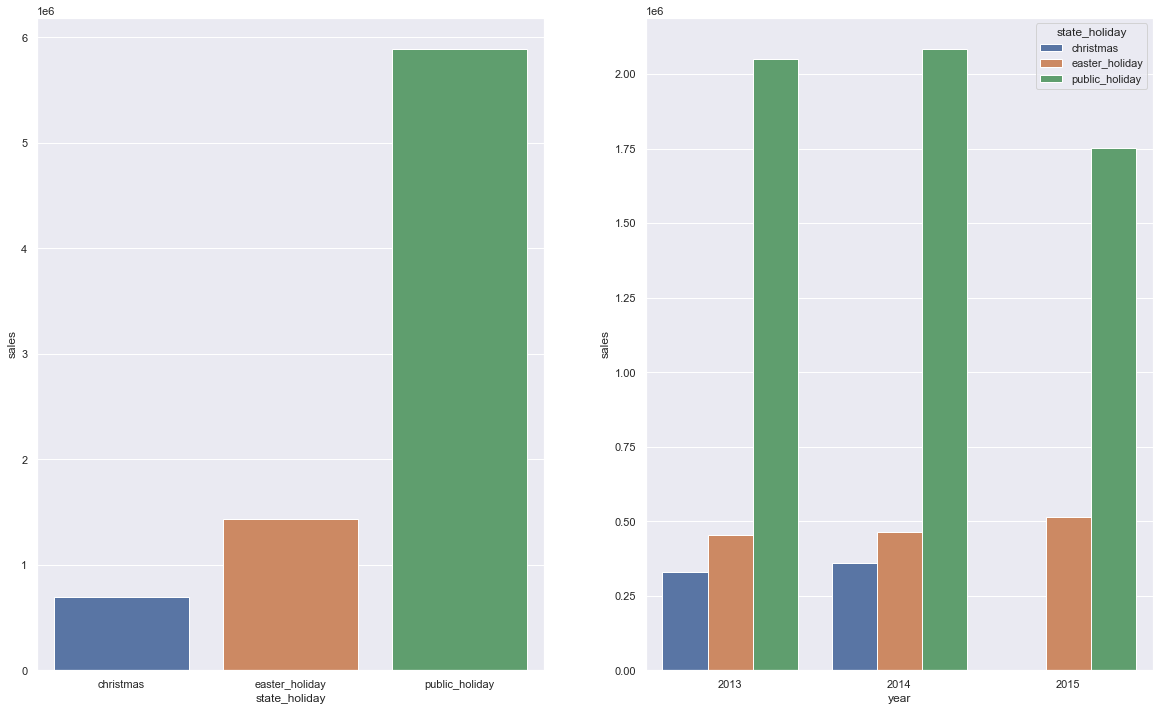

In [34]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(121)

aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(122)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales',hue='state_holiday', data=aux2);

#### H8. Lojas vedem mais ao longo dos anos
**False** Lojas vendem mensos ao longo dos anos

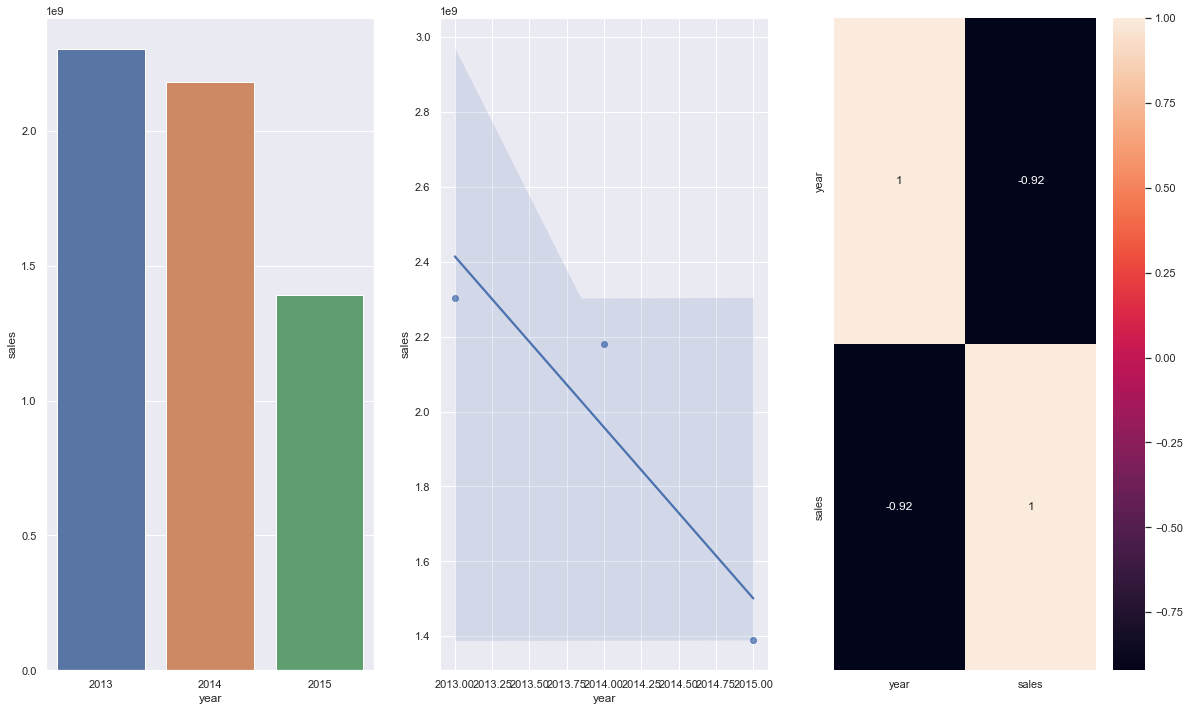

In [35]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(131)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(132)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(133)
sns.heatmap(aux1.corr(method = 'pearson'),annot=True);

#### H9. Lojas vendem mais no segundo semenstre do ano
**False** Lojas vendem no segundo sementre do ano

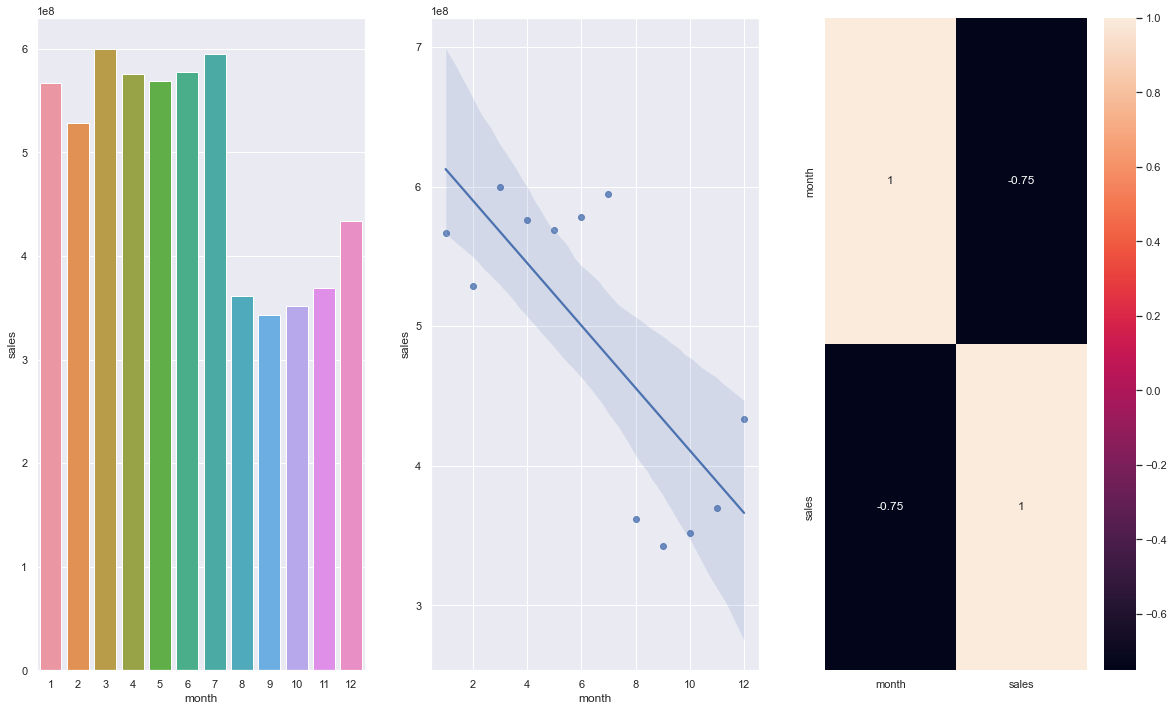

In [36]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(131)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(132)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(133)
sns.heatmap(aux1.corr(method = 'pearson'),annot=True);

#### H10. Lojas deveriam vender mais após o dia 10 de cada mês
**True** Lojas vendem mais depois do dia 10 de cada mes 

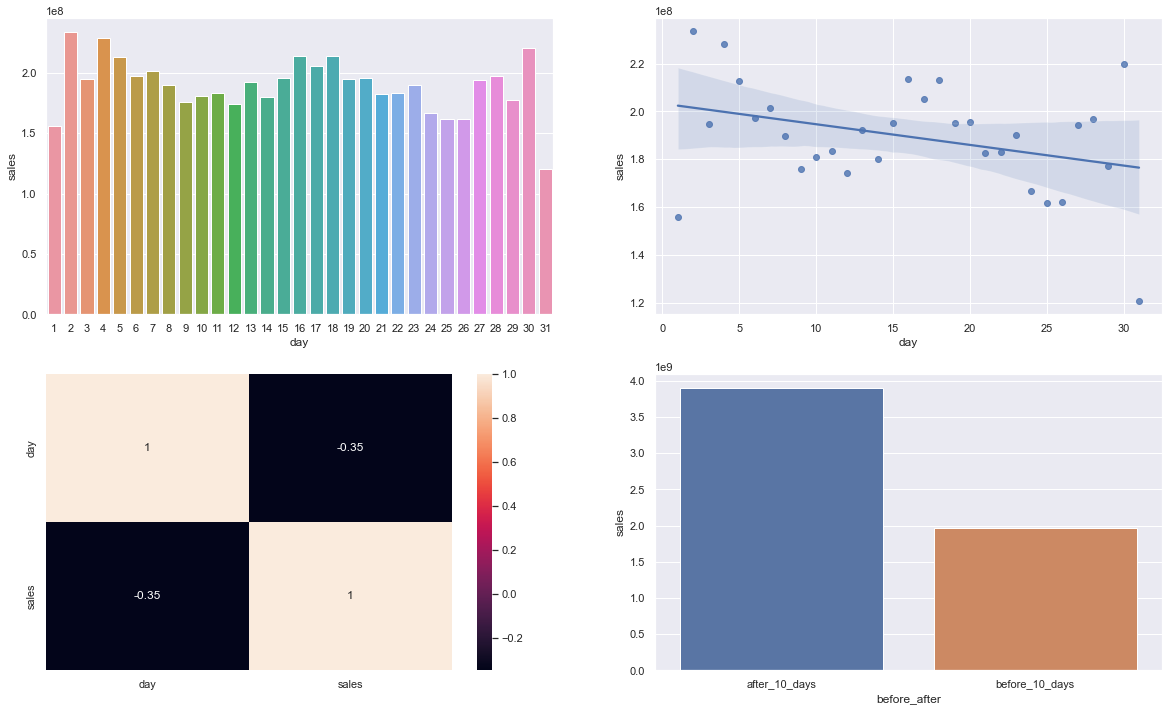

In [37]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(221)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(222)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(223)
sns.heatmap(aux1.corr(method = 'pearson'),annot=True);

plt.subplot(224)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

#### H11. Lojas vendem menos no final de semana 
**True** Lojas vendem mesnos no final de semana

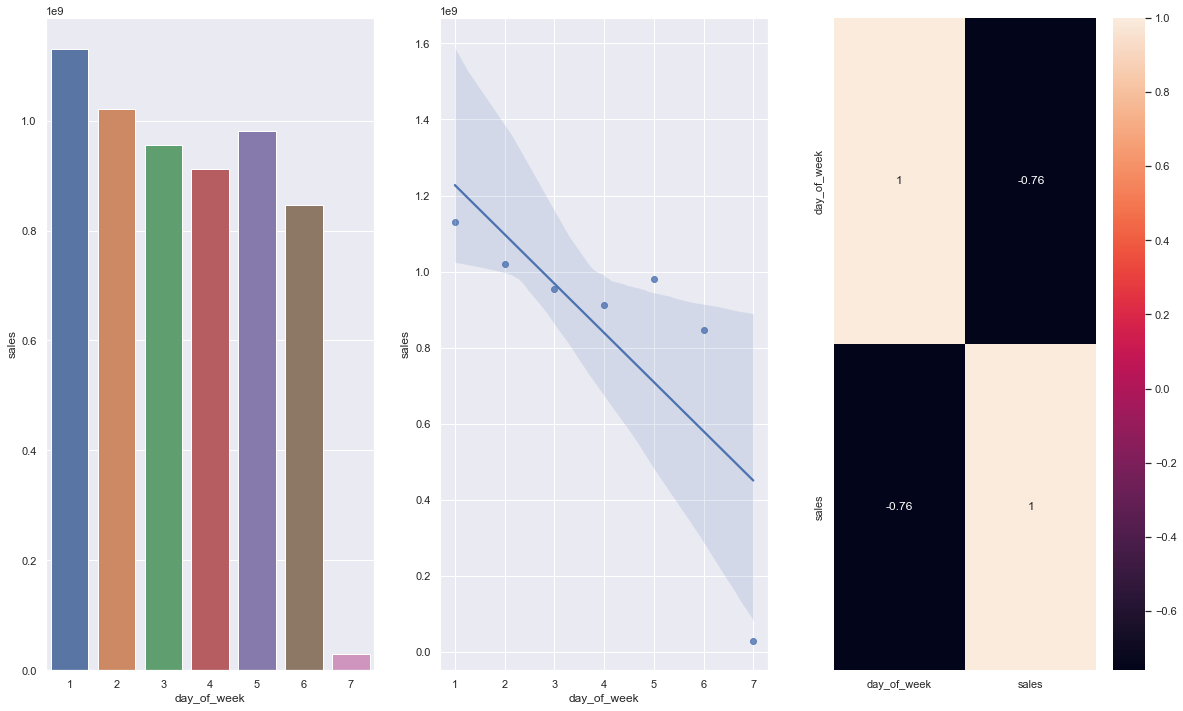

In [38]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(131)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(132)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(133)
sns.heatmap(aux1.corr(method = 'pearson'),annot=True);

#### H12. Lojas vendem menos durante feriados escolares
**True** Lojas vendem menos no feriados escolares, exceto julho e agosto, qunado vendem mais

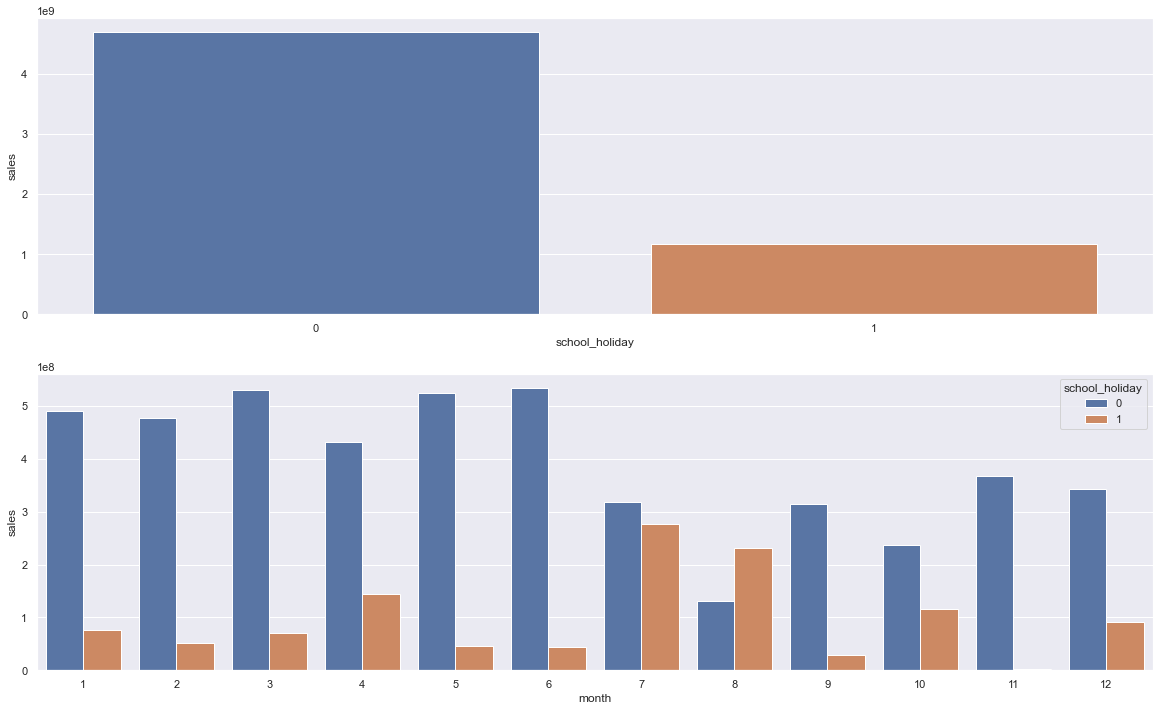

In [39]:
plt.subplot(211)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(212)
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales',hue='school_holiday',  data=aux2);

### 4.3.1 Hypothesis Summary

In [40]:
tab=[['Hipoteses','Conclusao','Relevancia'],
     ['H01','Falsa','Baixa'],
     ['H02','Falsa','Media'],
     ['H03','Falsa','Media'],
     ['H04','Falsa','Baixa'],
     ['H05','-','-'],
     ['H06','Falsa','Baixa'],
     ['H07','Falsa','Media'],
     ['H08','Falsa','Alta'],
     ['H09','Falsa','Alta'],
     ['H10','Verdadeira','Alta'],
     ['H11','Verdadeira','Alta'],
     ['H12','Verdadeira','Baixa'],]
print( tabulate( tab, headers='firstrow') )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H01          Falsa        Baixa
H02          Falsa        Media
H03          Falsa        Media
H04          Falsa        Baixa
H05          -            -
H06          Falsa        Baixa
H07          Falsa        Media
H08          Falsa        Alta
H09          Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.4. Análise Multivarida

### 4.3.1. Numerical Attributes - Método de Pearson

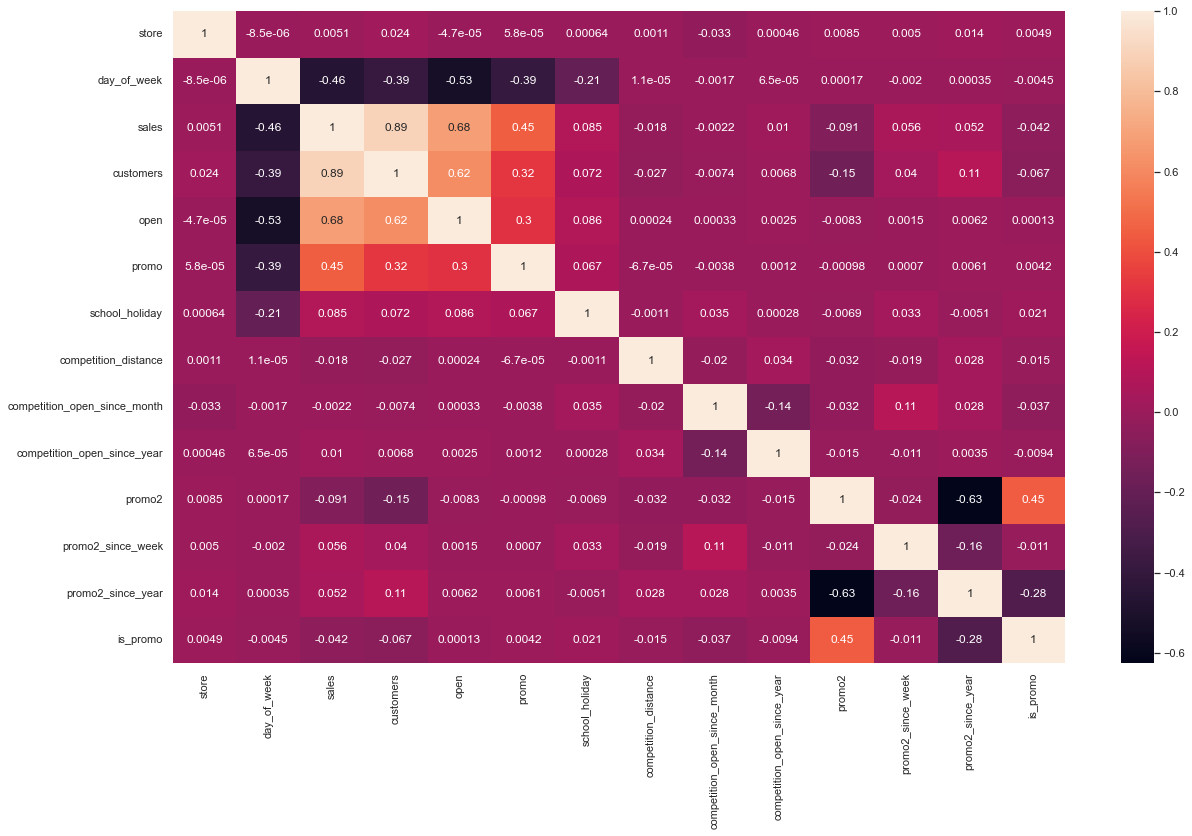

In [42]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# mais escuro  > a correlação negativa
# mais claro > a correlação posiiva

### 4.3.2. Categorical Attributes - Cramér's V - correlação entre todas as variaveis

In [116]:
def cramer_v (x,y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency (cm) [0]
    chi2corr = max (0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))   

In [115]:
a = df4.select_dtypes(include = 'object')

In [119]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]})

d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


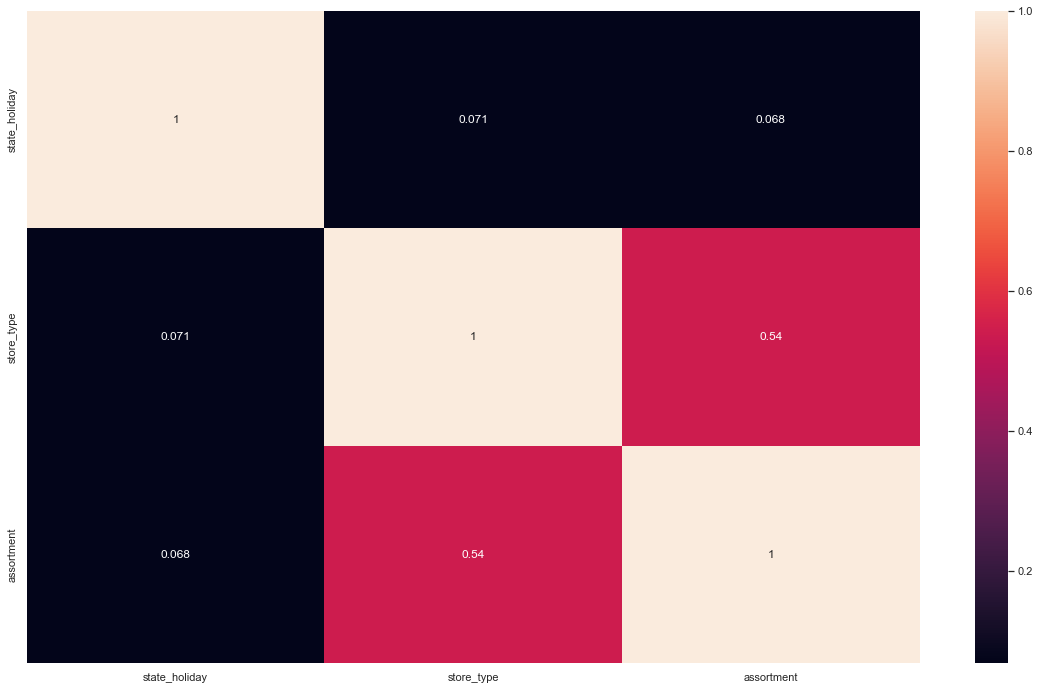

In [120]:
sns.heatmap(d, annot=True);

#### Draft

In [66]:
a.head()

,state_holiday,store_type,assortment,year_of_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [108]:
cm = pd.crosstab(a['state_holiday'], a['store_type']).values

In [109]:
chi2 = ss.chi2_contingency(cm)[0]

n = cm.sum ()

r, k = cm.shape

In [72]:
chi2

12792.159524019908

In [110]:
v = np.sqrt((chi2/n)) / (min(k-1, r-1))

In [111]:
v

0.04102914915782619